<a href="https://colab.research.google.com/github/debashisdotchatterjee/AI-ML-Assisted-Statistical-Spatio-Temporal-Prospectivity-Modelling-for-Critical-Minerals-Hackathon/blob/main/General_Theme_based_Simulation_(Bayesian_Statistical).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

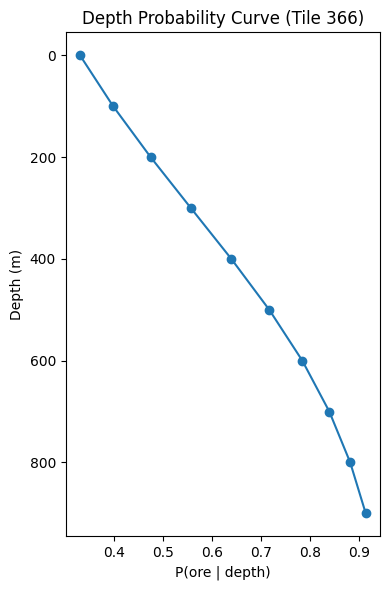

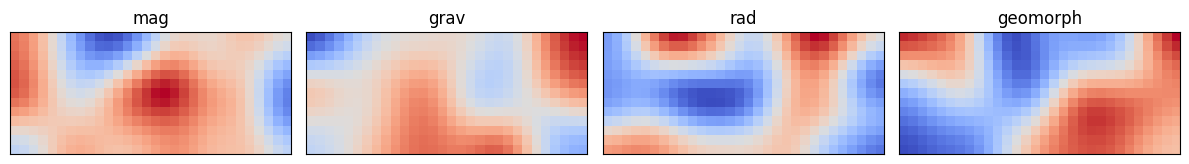

=== BAYESIAN PROSPECTIVITY SIMULATION SUMMARY ===
Output directory: bayes_prospectivity_sim
Files written:
 • intensity_map.png
 • occurrence_counts.png
 • psi_surface.png
 • depth_curve_tile_366.png
 • covariates_panel.png
 • tile_full_table.csv
 • top10_tiles.csv

Top‑10 tiles by prospectivity:
 tile_id  grid_x  grid_y      Psi
     366     6.0    12.0 0.346107
     367     7.0    12.0 0.345513
     365     5.0    12.0 0.342534
     368     8.0    12.0 0.340622
     364     4.0    12.0 0.336445
     336     6.0    11.0 0.335974
     337     7.0    11.0 0.335093
     335     5.0    11.0 0.332998
     369     9.0    12.0 0.332605
     338     8.0    11.0 0.330337


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.ndimage import gaussian_filter
from scipy.stats import poisson, norm, invgamma, dirichlet
import os, textwrap

# ================================================================
# 0. GLOBAL CONFIGURATION
# ================================================================
np.random.seed(2025)
OUT_DIR = "bayes_prospectivity_sim"
os.makedirs(OUT_DIR, exist_ok=True)

# ------------------------------------------------
# Helper for nice titles
# ------------------------------------------------
def nice(ax, title):
    ax.set_title("\n".join(textwrap.wrap(title, 45)))

# ================================================================
# 1. DEFINE THE TILING SYSTEM  (30 × 13 = 390 tiles)
#    Each tile ≈ 10 km × 10 km  → 100 km²
# ================================================================
nx, ny = 30, 13                       # grid along x (E–W) and y (N–S)
tile_ids = np.arange(nx * ny)
xs, ys = np.meshgrid(range(nx), range(ny))
xs, ys = xs.astype(float), ys.astype(float)   # indices 0…nx‑1 etc.

# For plotting make a physical mesh (10 km spacing just for labels)
x_phys, y_phys = xs * 10.0, ys * 10.0          # in km

# ================================================================
# 2. SIMULATE SPATIALLY CORRELATED COVARIATE FIELDS
# ================================================================
def make_field(sigma=1.0, length=3.0):
    noise = np.random.randn(ny, nx)
    return gaussian_filter(noise, sigma=length) * sigma

covariate_names = ["mag", "grav", "rad", "geomorph"]
covariates = {name: make_field() for name in covariate_names}

# Build design matrix X  (flatten grids → N × p)
X = np.column_stack([covariates[n].ravel() for n in covariate_names])
p = X.shape[1]
N_tiles = nx * ny

# ================================================================
# 3. GENERATE A LATENT GAUSSIAN RANDOM FIELD  ω(s)
#    (Matérn simplified here as smoothed Gaussian)
# ================================================================
omega = make_field(sigma=0.6, length=4.0).ravel()

# ================================================================
# 4. SET “TRUE” β  AND INTENSITY λ(s)
# ================================================================
beta_true = np.array([0.8, -0.6, 1.1, 0.4])
beta0_true = -1.2

eta = beta0_true + X @ beta_true + omega
Lambda_true = np.exp(eta)                              # intensity per tile

# ================================================================
# 5. SAMPLE OCCURRENCE COUNTS  N_k  ~  Poisson(Λ_k)
# ================================================================
N_counts = poisson.rvs(Lambda_true)

# ================================================================
# 6. EMPIRICAL PRIORS VIA PENALISED POISSON GLM  (ridge λ = 0.1)
#    (Here we solve via normal eq. approx.; for illustration only)
# ================================================================
lam_ridge = 0.1
XtX = X.T @ X + lam_ridge * np.eye(p)
XtY = X.T @ np.log(N_counts + 1)                       # log(count+1) proxy
beta_hat = np.linalg.solve(XtX, XtY)
Sigma_beta = np.linalg.inv(XtX)

# Draw one sample of β  and σ² from empirical priors (for fun)
beta_sample = norm.rvs(loc=beta_hat, scale=np.sqrt(np.diag(Sigma_beta)))
sigma2_sample = invgamma.rvs(a=3, scale=1.5)

# ================================================================
# 7. DEPTH MODEL  (HiS‑DOD simplified)
#    We discretise depth 0…900 m (10 layers of 100 m each)
# ================================================================
depth_layers = np.arange(0, 1000, 100)
n_z = len(depth_layers)

# true depth‑varying γ_j(z)  (one curve per covariate + intercept)
gamma0_curve = -0.5 + 0.003 * depth_layers            # intercept drifts
gamma_curves = np.vstack([                            # shape (p, n_z)
    0.4 * np.cos(0.003*depth_layers + ph) for ph in [0, 1, 2, 3]
])

# Logistic probability of ore‑hosting lithology
def logistic(x): return 1 / (1 + np.exp(-x))

P_ore = np.zeros((n_z, N_tiles))
for zi, z in enumerate(depth_layers):
    lin = gamma0_curve[zi] + (X @ gamma_curves[:, zi])
    P_ore[zi, :] = logistic(lin)

# Binary realisation Y(s,z)  (just one draw for the atlas)
Y_draw = (np.random.rand(n_z, N_tiles) < P_ore).astype(int)

# ================================================================
# 8. POSTERIOR‑PREDICTIVE PROSPECTIVITY SCORE  Ψ_k
#    (Monte‑Carlo average with tiny M = 20 for speed)
# ================================================================
M = 20
Psi = np.zeros(N_tiles)
Psi_depth = np.zeros((n_z, N_tiles))

for m in range(M):
    # Resample ω, β  from priors for diversity
    omega_m = make_field(sigma=np.sqrt(sigma2_sample), length=4.0).ravel()
    beta_m = norm.rvs(loc=beta_hat, scale=np.sqrt(np.diag(Sigma_beta)))
    eta_m = beta0_true + X @ beta_m + omega_m
    Lambda_m = np.exp(eta_m)
    Psi += 1 - np.exp(-Lambda_m)
    for zi in range(n_z):
        Psi_depth[zi, :] += P_ore[zi, :]               # reuse same P_ore
Psi /= M
Psi_depth /= M

# ================================================================
# 9. BUILD RESULTS TABLE
# ================================================================
results_df = pd.DataFrame({
    "tile_id": tile_ids,
    "grid_x": xs.ravel(),
    "grid_y": ys.ravel(),
    "Lambda_true": Lambda_true,
    "N_occ": N_counts,
    "Psi": Psi
})
top10 = results_df.nlargest(10, "Psi")

# ================================================================
# 10. PLOTTING SECTION
# ================================================================

## 10a. Intensity Λ(s)
fig, ax = plt.subplots(figsize=(8, 3.8))
im = ax.imshow(Lambda_true.reshape(ny, nx), origin='lower',
               cmap='plasma')
nice(ax, "True Intensity Λ(s) (LGCP)")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)
fig.colorbar(im, cax=cax, shrink=0.9)
plt.tight_layout()
fig.savefig(f"{OUT_DIR}/intensity_map.png", dpi=300)
plt.close(fig)

## 10b. Occurrence counts
fig, ax = plt.subplots(figsize=(8, 3.8))
im = ax.imshow(N_counts.reshape(ny, nx), origin='lower', cmap='viridis')
nice(ax, "Simulated Occurrence Counts N_k")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)
fig.colorbar(im, cax=cax, shrink=0.9)
plt.tight_layout()
fig.savefig(f"{OUT_DIR}/occurrence_counts.png", dpi=300)
plt.close(fig)

## 10c. Surface prospectivity Ψ_k
fig, ax = plt.subplots(figsize=(8, 3.8))
im = ax.imshow(Psi.reshape(ny, nx), origin='lower', cmap='inferno')
nice(ax, "Posterior‑Predictive Prospectivity Ψ_k")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.05)
fig.colorbar(im, cax=cax, shrink=0.9)
plt.tight_layout()
fig.savefig(f"{OUT_DIR}/psi_surface.png", dpi=300)
plt.close(fig)

## 10d. Depth probability section for best tile
best_tile = top10["tile_id"].iloc[0]
fig, ax = plt.subplots(figsize=(4, 6))
ax.plot(Psi_depth[:, best_tile], depth_layers, 'o-')
ax.invert_yaxis()
ax.set_xlabel("P(ore | depth)")
ax.set_ylabel("Depth (m)")
nice(ax, f"Depth Probability Curve\n(Tile {best_tile})")
plt.tight_layout()
fig.savefig(f"{OUT_DIR}/depth_curve_tile_{best_tile}.png", dpi=300)
plt.show()
plt.close(fig)

## 10e. Covariate fields – small multiples
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for i, name in enumerate(covariate_names):
    im = axes[i].imshow(covariates[name], origin='lower', cmap='coolwarm')
    axes[i].set_xticks([]); axes[i].set_yticks([])
    axes[i].set_title(name)
plt.tight_layout()
fig.savefig(f"{OUT_DIR}/covariates_panel.png", dpi=300)
plt.show()
plt.close(fig)

# ================================================================
# 11. SAVE TABLES
# ================================================================
results_df.to_csv(f"{OUT_DIR}/tile_full_table.csv", index=False)
top10.to_csv(f"{OUT_DIR}/top10_tiles.csv", index=False)

# ================================================================
# 12. CONSOLE OUTPUT
# ================================================================
print("=== BAYESIAN PROSPECTIVITY SIMULATION SUMMARY ===")
print(f"Output directory: {OUT_DIR}")
print("Files written:")
for fname in ["intensity_map.png", "occurrence_counts.png",
              "psi_surface.png", "depth_curve_tile_%d.png" % best_tile,
              "covariates_panel.png",
              "tile_full_table.csv", "top10_tiles.csv"]:
    print(" •", fname)
print("\nTop‑10 tiles by prospectivity:")
print(top10[["tile_id", "grid_x", "grid_y", "Psi"]].to_string(index=False))
